[[500000.]]
[[497081.07283929]]


(-2.0, 2.0, -2.0, 2.0)

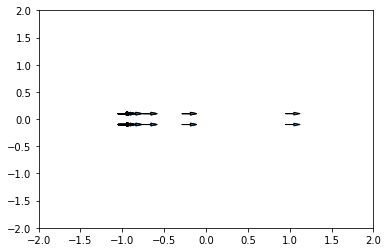

In [1]:
from unicycle_utils import plotUnicycle
from matplotlib import pyplot as plt
from algebra import *
from dynamicsandcostunicycle import *

def subgains(x,u):
    T = x.shape[1]
    # a t = T (T du sous probleme)
    Vxx = Qxx(x[:,-1:],np.zeros((m,1)))
    Vzx = np.zeros((n,n))
    Vzz = np.zeros((n,n))
    vx1 = qx(x[:,-1:],np.zeros((m,1)))
    vz1 = np.zeros((n,1))
    
    Hx = np.eye(n)
    Hz = -1.*np.eye((n))
    h1 = np.zeros((n,1))

    Kxl = []
    Kzl= []
    k1l = []
    
    for t in range(T-1,-1,-1):
        # a t < T
        Mxx = Qxx(x[:,t:t+1],u[:,t:t+1])+Fx(x[:,t:t+1],u[:,t:t+1]).T@Vxx@Fx(x[:,t:t+1],u[:,t:t+1])
        Mux = Fu(x[:,t:t+1],u[:,t:t+1]).T@Vxx@Fx(x[:,t:t+1],u[:,t:t+1]) + Qux(x[:,t:t+1],u[:,t:t+1])
        Mzu = Vzx@Fu(x[:,t:t+1],u[:,t:t+1])
        Mzx = Vzx@Fx(x[:,t:t+1],u[:,t:t+1])
        Mzz = Vzz
        Muu = Quu(x[:,t:t+1],u[:,t:t+1]) + Fu(x[:,t:t+1],u[:,t:t+1]).T@Vxx@Fu(x[:,t:t+1],u[:,t:t+1])
        mx1 = Fx(x[:,t:t+1],u[:,t:t+1]).T@vx1 + qx(x[:,t:t+1],u[:,t:t+1])
        mu1 = Fu(x[:,t:t+1],u[:,t:t+1]).T@vx1 + qu(x[:,t:t+1],u[:,t:t+1])
        mz1 = vz1
        Nx = Hx@Fx(x[:,t:t+1],u[:,t:t+1])
        Nu = Hx@Fu(x[:,t:t+1],u[:,t:t+1])
        Nz = Hz
        n1 = h1 + Hx@f1(x[:,t:t+1],u[:,t:t+1])
        Zw = null_space(Nu)
        Py = orth(Nu.T)
        A = Py@linalg.pinv(Nu@Py)
        B = Zw@linalg.inv(Zw.T@Muu@Zw)@(Zw.T)
        
        #calcul gains
        Kx = -A@Nx -B@Mux
        Kz = -A@Nz -B@(Mzu.T)
        k1 = -A@n1 -B@mu1
        Kxl.append(Kx)
        Kzl.append(Kz)
        k1l.append(k1)
        if (False):
            print("t={}".format(t))
            print("Nu={}".format(Nu))
            print("Py={}".format(Py))
            print("Zw={}".format(Zw))
            print("A={}".format(A))
            print("B={}".format(B))
            if (Py.shape==((m,m))):
                print("Py==Im ? : {}".format((Py==np.eye(m)).all()))
            print("A*Nu == Im ? : {}".format((A@Nu==np.eye(m)).all()))
            print("A*Nu is close to Im ? : {}".format(np.allclose(A@Nu,np.eye(m))))
            print("Hxt+1 :{}".format(Hx))    
        #maj cout
        Vxx = Mxx+Mux.T@Kx+Kx.T@Mux+Kx.T@Muu@Kx
        Vzx = Mzx+Mzu@Kx+Kz.T@Mux+Kz.T@Muu@Kx
        Vzz = Mzz+Kz.T@Mzu.T+Mzu@Kz+Kz.T@Muu@Kz
        vx1 = mx1+Kx.T@mu1+(Mux.T+Kx.T@Muu)@k1
        vz1 = mz1+Mzu@k1+Kz.T@mu1+Kz.T@Muu@k1
        Hx = (np.eye(n)-Nu@A)@Nx
        Hz = (np.eye(n)-Nu@A)@Nz
        h1 = (np.eye(n)-Nu@A)@n1
    return Kxl,Kzl,k1l

def subroll(x,u,Kx,Kz,k1):
    T = len(Kx)
    for t in range(T):
        u[:,t:t+1] = Kx[-1]@x[:,t:t+1]+Kz[-1]@x[:,-1:]+k1[-1]
        x[:,t+1:t+2] = next_state(x[:,t:t+1],u[:,t:t+1])
        Kx.pop()
        Kz.pop()
        k1.pop()
    return x,u

def constrainedLQR(x,u):
    Kxl,Kzl,k1l = subgains(x,u)
    return subroll(x,u,Kxl,Kzl,k1l)
    
def calcul_cout(x,u):
    sumcosts = 0.
    for t in range(0,T):
        sumcosts += cost(x[:,t:t+1],u[:,t:t+1])
    #sumcosts += finalcost(x[:,T:T+1])
    return sumcosts

print(calcul_cout(x,u))
x,u = constrainedLQR(x,u)
print(calcul_cout(x,u))


for t in range(T+1):
    plotUnicycle(x[:,t:t+1])
plt.axis([-2, 2., -2., 2.])